In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

/Users/anik/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

In [3]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    'Tomato',
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_name = df.class_names

In [5]:
def train_test_vali(df,train = 0.75):
    vali = (1-train)/2
    #test = vali

    x = int(len(df)*train)
    df_train = df.take(x)

    y = int(len(df)*vali)
    df_vali = df.skip(x).take(y)

    df_test = df.skip(x).skip(y)

    return df_train,df_vali,df_test

In [6]:
train,vali,test = train_test_vali(df,train=0.8)

In [13]:
len(train)

400

In [7]:
train_df = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
vali_df= vali.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [9]:
data = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomFlip('horizontal_and_vertical')
]
)

In [30]:
cnn = models.Sequential([
    resize,
    data,

    layers.Conv2D(10,kernel_size=(3,3),activation='relu',input_shape = (32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(10,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(10,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(10,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    

    layers.Flatten(),
    
    layers.Dense(10,activation='relu'),
    layers.Dense(10,activation='softmax')

])

cnn.build(input_shape=(32,256,256,3))

/Users/anik/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 254, 254, 10)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 127, 127, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 125, 125, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 62, 62, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 60, 60, 10)       │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 30, 30, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 28, 28, 10)       │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 14, 14, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 1960)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 10)               │        19,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 10)               │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,730 (88.79 KB)

 Trainable params: 22,730 (88.79 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
cnn.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [34]:
cnn.fit(
    train_df,
    batch_size = 32,
    validation_data = vali_df,
    verbose = 1,
    epochs = 10
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 127s 318ms/step - accuracy: 0.2624 - loss: 2.0159 - val_accuracy: 0.3781 - val_loss: 1.7601
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 129s 322ms/step - accuracy: 0.3884 - loss: 1.7242 - val_accuracy: 0.4313 - val_loss: 1.6094
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 126s 315ms/step - accuracy: 0.4215 - loss: 1.6239 - val_accuracy: 0.3619 - val_loss: 1.6798
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 131s 327ms/step - accuracy: 0.4341 - loss: 1.5422 - val_accuracy: 0.3681 - val_loss: 1.6140
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 132s 330ms/step - accuracy: 0.4874 - loss: 1.4815 - val_accuracy: 0.4863 - val_loss: 1.4814
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 132s 329ms/step - accuracy: 0.4898 - loss: 1.4345 - val_accuracy: 0.4806 - val_loss: 1.5182
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 132s 331ms/step - accuracy: 0.4942 - loss: 1.4056 - val_accuracy: 0.4525 - val_loss: 1.5218
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 132s 330ms/step - accuracy: 0.5095 -

In [14]:
cnn

<Sequential name=sequential_3, built=True>

In [39]:
cnn.evaluate(test_df)

51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.4127 - loss: 1.5910


[1.569162130355835, 0.4264431893825531]

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-07-10 13:38:50.240699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


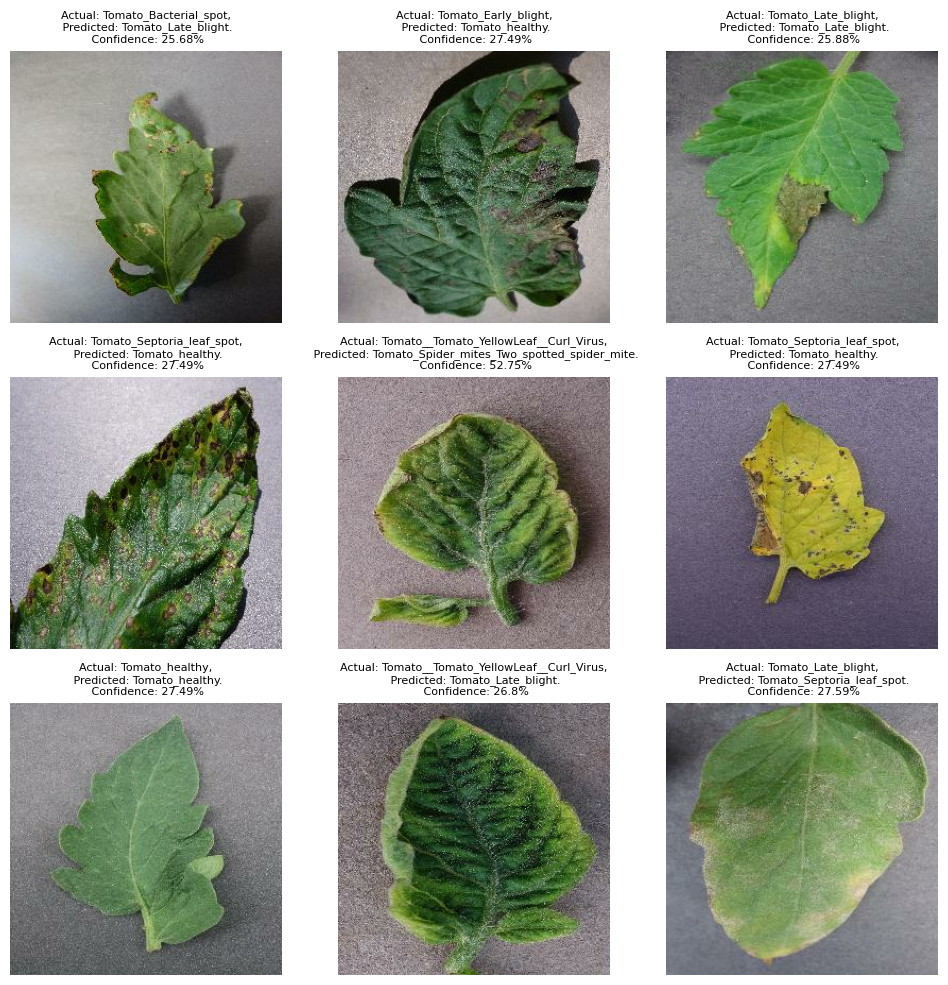

In [38]:
plt.figure(figsize=(12, 12))
for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(cnn, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%",fontsize = 8)
        
        plt.axis("off")

In [54]:
type(cnn)

keras.src.models.sequential.Sequential

In [55]:
import joblib as joblib

In [56]:
joblib.dump(cnn,'ten_epoch')

['ten_epoch']